In [1]:
import os
import wandb

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
wandb.login()

wandb: Currently logged in as: jelmerwolterink. Use `wandb login --relogin` to force relogin


True

In [2]:
!pip install dival
!pip install kornia
!pip install monai

  Using cached dival-0.6.1-py3-none-any.whl (101 kB)


  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)


  Using cached h5py-3.8.0-cp37-cp37m-macosx_10_9_x86_64.whl (3.2 MB)


  Using cached odl-0.7.0-py2.py3-none-any.whl (778 kB)


     ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/491.3 kB 60.4 MB/s eta 0:00:01

     ━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/491.3 kB 1.8 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 225.3/491.3 kB 1.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 225.3/491.3 kB 1.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━ 358.4/491.3 kB 1.6 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━ 368.6/491.3 kB 1.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 1.4 MB/s eta 0:00:00


  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


  Using cached kornia-0.6.12-py2.py3-none-any.whl (653 kB)


In [3]:
import dival

dataset = dival.get_standard_dataset('ellipses', impl='skimage')
dat_gen = dataset.generator(part='train')

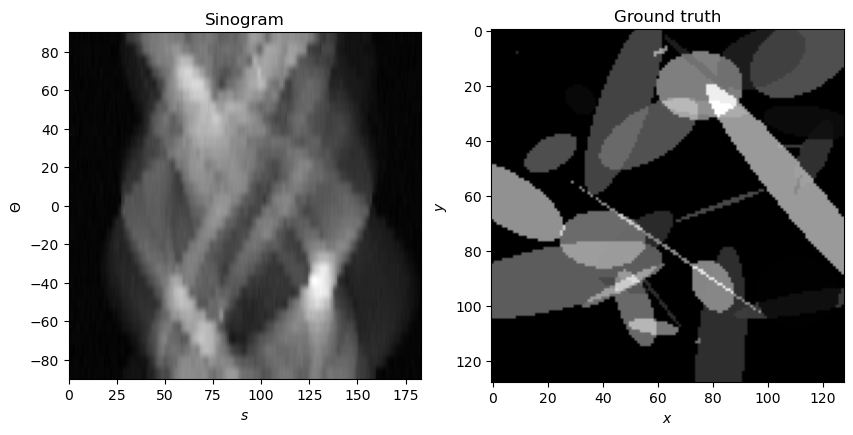

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Get a sample from the generator
sinogram, ground_truth = next(dat_gen)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Show the sinogram
axs[0].imshow(sinogram, cmap='gray', extent=[0, 183, -90, 90])
axs[0].set_title('Sinogram')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$\Theta$')

# Show the ground truth image
axs[1].imshow(ground_truth, cmap='gray')
axs[1].set_title('Ground truth')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
plt.show()   

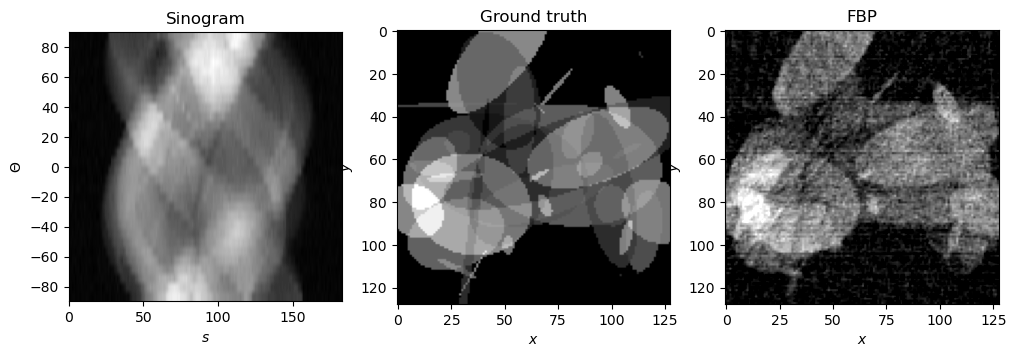

In [5]:
import skimage.transform as sktr

# Get a sample from the generator
sinogram, ground_truth = next(dat_gen)
sinogram = np.asarray(sinogram).transpose()

# This defines the projectiona angles
theta = np.linspace(-90., 90., sinogram.shape[1], endpoint=True)

# Perform FBP
fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(sinogram.transpose(), cmap='gray', extent=[0, 183, -90, 90])
axs[0].set_title('Sinogram')
axs[0].set_xlabel('$s$')
axs[0].set_ylabel('$\Theta$')
axs[1].imshow(ground_truth, cmap='gray', clim=[0, 1])
axs[1].set_title('Ground truth')
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$y$')
axs[2].imshow(fbp_recon, cmap='gray', clim=[0, 1])
axs[2].set_title('FBP')
axs[2].set_xlabel('$x$')
axs[2].set_ylabel('$y$')
plt.show()

In [6]:
import skimage.metrics as skme

print('SSIM = {:.2f}'.format(skme.structural_similarity(np.asarray(ground_truth), fbp_recon, data_range=np.max(ground_truth)-np.min(ground_truth))))
# ⌨ FILL IN

SSIM = 0.29


In [7]:
import tqdm
import monai

theta = np.linspace(-90., 90., sinogram.shape[1], endpoint=True)

# Make a generator for the training part of the dataset
train_gen = dataset.generator(part='train')
train_samples = []

# Make a list of (in this case) 512 random training samples. We store the filtered backprojection (FBP) and ground truth image
# in a dictionary for each sample, and add these to a list.
for ns in tqdm.tqdm(range(512)):
    sinogram, ground_truth = next(train_gen)
    sinogram = np.asarray(sinogram).transpose()
    fbp_recon = sktr.iradon(sinogram, theta=theta, filter_name='ramp')[28:-27, 28:-27]
    train_samples.append({'fbp': fbp_recon, 'ground_truth': np.asarray(ground_truth)})

# You can add or remove transforms here
train_transform = monai.transforms.Compose([
    monai.transforms.AddChanneld(keys=['fbp', 'ground_truth'])
])    

# Use the list of dictionaries and the transform to initialize a MONAI CacheDataset
train_dataset = monai.data.CacheDataset(train_samples, transform=train_transform)    

  0%|                                                 | 0/512 [00:00<?, ?it/s]

  0%|                                         | 1/512 [00:00<02:30,  3.39it/s]

  0%|▏                                        | 2/512 [00:00<02:25,  3.51it/s]

  1%|▏                                        | 3/512 [00:00<02:21,  3.59it/s]

  1%|▎                                        | 4/512 [00:01<02:20,  3.63it/s]

  1%|▍                                        | 5/512 [00:01<02:18,  3.66it/s]

  1%|▍                                        | 6/512 [00:01<02:17,  3.69it/s]

  1%|▌                                        | 7/512 [00:01<02:16,  3.70it/s]

  2%|▋                                        | 8/512 [00:02<02:15,  3.71it/s]

  2%|▋                                        | 9/512 [00:02<02:15,  3.70it/s]

  2%|▊                                       | 10/512 [00:02<02:15,  3.71it/s]

  2%|▊                                       | 11/512 [00:02<02:14,  3.72it/s]

  2%|▉                                       | 12/512 [00:03<02:14,  3.73it/s]

  3%|█                                       | 13/512 [00:03<02:13,  3.73it/s]

  3%|█                                       | 14/512 [00:03<02:13,  3.73it/s]

  3%|█▏                                      | 15/512 [00:04<02:13,  3.74it/s]

  3%|█▎                                      | 16/512 [00:04<02:12,  3.74it/s]

  3%|█▎                                      | 17/512 [00:04<02:12,  3.74it/s]

  4%|█▍                                      | 18/512 [00:04<02:12,  3.74it/s]

  4%|█▍                                      | 19/512 [00:05<02:11,  3.74it/s]

  4%|█▌                                      | 20/512 [00:05<02:11,  3.74it/s]

  4%|█▋                                      | 21/512 [00:05<02:11,  3.73it/s]

  4%|█▋                                      | 22/512 [00:05<02:10,  3.74it/s]

  4%|█▊                                      | 23/512 [00:06<02:10,  3.73it/s]

  5%|█▉                                      | 24/512 [00:06<02:10,  3.73it/s]

  5%|█▉                                      | 25/512 [00:06<02:10,  3.73it/s]

  5%|██                                      | 26/512 [00:07<02:10,  3.72it/s]

  5%|██                                      | 27/512 [00:07<02:10,  3.72it/s]

  5%|██▏                                     | 28/512 [00:07<02:11,  3.69it/s]

  6%|██▎                                     | 29/512 [00:07<02:10,  3.69it/s]

  6%|██▎                                     | 30/512 [00:08<02:10,  3.70it/s]

  6%|██▍                                     | 31/512 [00:08<02:10,  3.67it/s]

  6%|██▌                                     | 32/512 [00:08<02:11,  3.64it/s]

  6%|██▌                                     | 33/512 [00:08<02:12,  3.63it/s]

  7%|██▋                                     | 34/512 [00:09<02:12,  3.61it/s]

  7%|██▋                                     | 35/512 [00:09<02:12,  3.61it/s]

  7%|██▊                                     | 36/512 [00:09<02:12,  3.58it/s]

  7%|██▉                                     | 37/512 [00:10<02:12,  3.60it/s]

  7%|██▉                                     | 38/512 [00:10<02:11,  3.60it/s]

  8%|███                                     | 39/512 [00:10<02:11,  3.61it/s]

  8%|███▏                                    | 40/512 [00:10<02:09,  3.63it/s]

  8%|███▏                                    | 41/512 [00:11<02:09,  3.62it/s]

  8%|███▎                                    | 42/512 [00:11<02:08,  3.65it/s]

  8%|███▎                                    | 43/512 [00:11<02:07,  3.67it/s]

  9%|███▍                                    | 44/512 [00:12<02:18,  3.38it/s]

  9%|███▌                                    | 45/512 [00:12<02:15,  3.45it/s]

  9%|███▌                                    | 46/512 [00:12<02:12,  3.53it/s]

  9%|███▋                                    | 47/512 [00:12<02:10,  3.56it/s]

  9%|███▊                                    | 48/512 [00:13<02:08,  3.60it/s]

 10%|███▊                                    | 49/512 [00:13<02:07,  3.63it/s]

 10%|███▉                                    | 50/512 [00:13<02:06,  3.65it/s]

 10%|███▉                                    | 51/512 [00:13<02:08,  3.59it/s]

 10%|████                                    | 52/512 [00:14<02:08,  3.59it/s]

 10%|████▏                                   | 53/512 [00:14<02:07,  3.60it/s]

 11%|████▏                                   | 54/512 [00:14<02:06,  3.62it/s]

 11%|████▎                                   | 55/512 [00:15<02:06,  3.61it/s]

 11%|████▍                                   | 56/512 [00:15<02:05,  3.64it/s]

 11%|████▍                                   | 57/512 [00:15<02:04,  3.66it/s]

 11%|████▌                                   | 58/512 [00:15<02:03,  3.68it/s]

 12%|████▌                                   | 59/512 [00:16<02:02,  3.69it/s]

 12%|████▋                                   | 60/512 [00:16<02:02,  3.69it/s]

 12%|████▊                                   | 61/512 [00:16<02:01,  3.71it/s]

 12%|████▊                                   | 62/512 [00:16<02:01,  3.71it/s]

 12%|████▉                                   | 63/512 [00:17<02:00,  3.71it/s]

 12%|█████                                   | 64/512 [00:17<02:01,  3.70it/s]

 13%|█████                                   | 65/512 [00:17<02:00,  3.70it/s]

 13%|█████▏                                  | 66/512 [00:18<02:00,  3.70it/s]

 13%|█████▏                                  | 67/512 [00:18<02:00,  3.71it/s]

 13%|█████▎                                  | 68/512 [00:18<01:59,  3.71it/s]

 13%|█████▍                                  | 69/512 [00:18<01:59,  3.70it/s]

 14%|█████▍                                  | 70/512 [00:19<01:59,  3.70it/s]

 14%|█████▌                                  | 71/512 [00:19<01:59,  3.70it/s]

 14%|█████▋                                  | 72/512 [00:19<01:58,  3.70it/s]

 14%|█████▋                                  | 73/512 [00:19<01:59,  3.69it/s]

 14%|█████▊                                  | 74/512 [00:20<01:58,  3.70it/s]

 15%|█████▊                                  | 75/512 [00:20<01:58,  3.67it/s]

 15%|█████▉                                  | 76/512 [00:20<01:58,  3.69it/s]

 15%|██████                                  | 77/512 [00:21<01:58,  3.69it/s]

 15%|██████                                  | 78/512 [00:21<01:57,  3.68it/s]

 15%|██████▏                                 | 79/512 [00:21<01:57,  3.67it/s]

 16%|██████▎                                 | 80/512 [00:21<01:57,  3.67it/s]

 16%|██████▎                                 | 81/512 [00:22<01:57,  3.68it/s]

 16%|██████▍                                 | 82/512 [00:22<01:56,  3.69it/s]

 16%|██████▍                                 | 83/512 [00:22<01:56,  3.70it/s]

 16%|██████▌                                 | 84/512 [00:22<01:55,  3.70it/s]

 17%|██████▋                                 | 85/512 [00:23<01:55,  3.70it/s]

 17%|██████▋                                 | 86/512 [00:23<01:55,  3.70it/s]

 17%|██████▊                                 | 87/512 [00:23<01:54,  3.70it/s]

 17%|██████▉                                 | 88/512 [00:23<01:54,  3.69it/s]

 17%|██████▉                                 | 89/512 [00:24<02:01,  3.49it/s]

 18%|███████                                 | 90/512 [00:24<01:58,  3.55it/s]

 18%|███████                                 | 91/512 [00:24<01:56,  3.61it/s]

 18%|███████▏                                | 92/512 [00:25<01:55,  3.65it/s]

 18%|███████▎                                | 93/512 [00:25<01:54,  3.67it/s]

 18%|███████▎                                | 94/512 [00:25<01:53,  3.70it/s]

 19%|███████▍                                | 95/512 [00:25<01:52,  3.71it/s]

 19%|███████▌                                | 96/512 [00:26<01:51,  3.72it/s]

 19%|███████▌                                | 97/512 [00:26<01:51,  3.74it/s]

 19%|███████▋                                | 98/512 [00:26<01:50,  3.74it/s]

 19%|███████▋                                | 99/512 [00:26<01:50,  3.74it/s]

 20%|███████▌                               | 100/512 [00:27<01:50,  3.74it/s]

 20%|███████▋                               | 101/512 [00:27<01:50,  3.73it/s]

 20%|███████▊                               | 102/512 [00:27<01:49,  3.73it/s]

 20%|███████▊                               | 103/512 [00:28<01:49,  3.74it/s]

 20%|███████▉                               | 104/512 [00:28<01:48,  3.75it/s]

 21%|███████▉                               | 105/512 [00:28<01:48,  3.75it/s]

 21%|████████                               | 106/512 [00:28<01:48,  3.75it/s]

 21%|████████▏                              | 107/512 [00:29<01:47,  3.75it/s]

 21%|████████▏                              | 108/512 [00:29<01:47,  3.75it/s]

 21%|████████▎                              | 109/512 [00:29<01:47,  3.73it/s]

 21%|████████▍                              | 110/512 [00:29<01:47,  3.73it/s]

 22%|████████▍                              | 111/512 [00:30<01:47,  3.73it/s]

 22%|████████▌                              | 112/512 [00:30<01:47,  3.71it/s]

 22%|████████▌                              | 113/512 [00:30<01:47,  3.71it/s]

 22%|████████▋                              | 114/512 [00:31<01:47,  3.72it/s]

 22%|████████▊                              | 115/512 [00:31<01:46,  3.73it/s]

 23%|████████▊                              | 116/512 [00:31<01:46,  3.72it/s]

 23%|████████▉                              | 117/512 [00:31<01:46,  3.72it/s]

 23%|████████▉                              | 118/512 [00:32<01:45,  3.73it/s]

 23%|█████████                              | 119/512 [00:32<01:45,  3.73it/s]

 23%|█████████▏                             | 120/512 [00:32<01:44,  3.73it/s]

 24%|█████████▏                             | 121/512 [00:32<01:44,  3.74it/s]

 24%|█████████▎                             | 122/512 [00:33<01:44,  3.74it/s]

 24%|█████████▎                             | 123/512 [00:33<01:44,  3.74it/s]

 24%|█████████▍                             | 124/512 [00:33<01:43,  3.74it/s]

 24%|█████████▌                             | 125/512 [00:33<01:43,  3.73it/s]

 25%|█████████▌                             | 126/512 [00:34<01:43,  3.73it/s]

 25%|█████████▋                             | 127/512 [00:34<01:43,  3.74it/s]

 25%|█████████▊                             | 128/512 [00:34<01:43,  3.72it/s]

 25%|█████████▊                             | 129/512 [00:35<01:42,  3.73it/s]

 25%|█████████▉                             | 130/512 [00:35<01:42,  3.73it/s]

 26%|█████████▉                             | 131/512 [00:35<01:42,  3.73it/s]

 26%|██████████                             | 132/512 [00:35<01:41,  3.73it/s]

 26%|██████████▏                            | 133/512 [00:36<01:42,  3.71it/s]

 26%|██████████▏                            | 134/512 [00:36<01:41,  3.71it/s]

 26%|██████████▎                            | 135/512 [00:36<01:41,  3.72it/s]

 27%|██████████▎                            | 136/512 [00:36<01:43,  3.62it/s]

 27%|██████████▍                            | 137/512 [00:37<01:43,  3.61it/s]

 27%|██████████▌                            | 138/512 [00:37<01:43,  3.61it/s]

 27%|██████████▌                            | 139/512 [00:37<01:43,  3.62it/s]

 27%|██████████▋                            | 140/512 [00:38<01:42,  3.63it/s]

 28%|██████████▋                            | 141/512 [00:38<01:41,  3.66it/s]

 28%|██████████▊                            | 142/512 [00:38<01:41,  3.66it/s]

 28%|██████████▉                            | 143/512 [00:38<01:40,  3.66it/s]

 28%|██████████▉                            | 144/512 [00:39<01:39,  3.68it/s]

 28%|███████████                            | 145/512 [00:39<01:39,  3.68it/s]

 29%|███████████                            | 146/512 [00:39<01:40,  3.65it/s]

 29%|███████████▏                           | 147/512 [00:39<01:39,  3.67it/s]

 29%|███████████▎                           | 148/512 [00:40<01:38,  3.68it/s]

 29%|███████████▎                           | 149/512 [00:40<01:38,  3.68it/s]

 29%|███████████▍                           | 150/512 [00:40<01:37,  3.71it/s]

 29%|███████████▌                           | 151/512 [00:41<01:36,  3.72it/s]

 30%|███████████▌                           | 152/512 [00:41<01:36,  3.73it/s]

 30%|███████████▋                           | 153/512 [00:41<01:36,  3.72it/s]

 30%|███████████▋                           | 154/512 [00:41<01:35,  3.73it/s]

 30%|███████████▊                           | 155/512 [00:42<01:36,  3.72it/s]

 30%|███████████▉                           | 156/512 [00:42<01:35,  3.73it/s]

 31%|███████████▉                           | 157/512 [00:42<01:35,  3.73it/s]

 31%|████████████                           | 158/512 [00:42<01:36,  3.69it/s]

 31%|████████████                           | 159/512 [00:43<01:38,  3.57it/s]

 31%|████████████▏                          | 160/512 [00:43<01:37,  3.62it/s]

 31%|████████████▎                          | 161/512 [00:43<01:36,  3.65it/s]

 32%|████████████▎                          | 162/512 [00:43<01:35,  3.68it/s]

 32%|████████████▍                          | 163/512 [00:44<01:34,  3.70it/s]

 32%|████████████▍                          | 164/512 [00:44<01:33,  3.72it/s]

 32%|████████████▌                          | 165/512 [00:44<01:33,  3.72it/s]

 32%|████████████▋                          | 166/512 [00:45<01:32,  3.73it/s]

 33%|████████████▋                          | 167/512 [00:45<01:32,  3.73it/s]

 33%|████████████▊                          | 168/512 [00:45<01:32,  3.73it/s]

 33%|████████████▊                          | 169/512 [00:45<01:31,  3.73it/s]

 33%|████████████▉                          | 170/512 [00:46<01:31,  3.74it/s]

 33%|█████████████                          | 171/512 [00:46<01:31,  3.74it/s]

 34%|█████████████                          | 172/512 [00:46<01:31,  3.74it/s]

 34%|█████████████▏                         | 173/512 [00:46<01:30,  3.74it/s]

 34%|█████████████▎                         | 174/512 [00:47<01:30,  3.74it/s]

 34%|█████████████▎                         | 175/512 [00:47<01:30,  3.73it/s]

 34%|█████████████▍                         | 176/512 [00:47<01:29,  3.73it/s]

 35%|█████████████▍                         | 177/512 [00:48<01:29,  3.74it/s]

 35%|█████████████▌                         | 178/512 [00:48<01:29,  3.74it/s]

 35%|█████████████▋                         | 179/512 [00:48<01:28,  3.74it/s]

 35%|█████████████▋                         | 180/512 [00:48<01:29,  3.71it/s]

 35%|█████████████▊                         | 181/512 [00:49<01:30,  3.68it/s]

 36%|█████████████▊                         | 182/512 [00:49<01:32,  3.58it/s]

 36%|█████████████▉                         | 183/512 [00:49<01:31,  3.61it/s]

 36%|██████████████                         | 184/512 [00:49<01:30,  3.64it/s]

 36%|██████████████                         | 185/512 [00:50<01:29,  3.64it/s]

 36%|██████████████▏                        | 186/512 [00:50<01:28,  3.67it/s]

 37%|██████████████▏                        | 187/512 [00:50<01:28,  3.69it/s]

 37%|██████████████▎                        | 188/512 [00:51<01:28,  3.68it/s]

 37%|██████████████▍                        | 189/512 [00:51<01:27,  3.70it/s]

 37%|██████████████▍                        | 190/512 [00:51<01:26,  3.72it/s]

 37%|██████████████▌                        | 191/512 [00:51<01:26,  3.72it/s]

 38%|██████████████▋                        | 192/512 [00:52<01:25,  3.73it/s]

 38%|██████████████▋                        | 193/512 [00:52<01:25,  3.73it/s]

 38%|██████████████▊                        | 194/512 [00:52<01:25,  3.73it/s]

 38%|██████████████▊                        | 195/512 [00:52<01:25,  3.72it/s]

 38%|██████████████▉                        | 196/512 [00:53<01:25,  3.71it/s]

 38%|███████████████                        | 197/512 [00:53<01:24,  3.71it/s]

 39%|███████████████                        | 198/512 [00:53<01:25,  3.68it/s]

 39%|███████████████▏                       | 199/512 [00:53<01:24,  3.69it/s]

 39%|███████████████▏                       | 200/512 [00:54<01:24,  3.70it/s]

 39%|███████████████▎                       | 201/512 [00:54<01:23,  3.71it/s]

 39%|███████████████▍                       | 202/512 [00:54<01:23,  3.72it/s]

 40%|███████████████▍                       | 203/512 [00:55<01:28,  3.48it/s]

 40%|███████████████▌                       | 204/512 [00:55<01:27,  3.54it/s]

 40%|███████████████▌                       | 205/512 [00:55<01:26,  3.55it/s]

 40%|███████████████▋                       | 206/512 [00:55<01:24,  3.60it/s]

 40%|███████████████▊                       | 207/512 [00:56<01:23,  3.65it/s]

 41%|███████████████▊                       | 208/512 [00:56<01:22,  3.67it/s]

 41%|███████████████▉                       | 209/512 [00:56<01:22,  3.69it/s]

 41%|███████████████▉                       | 210/512 [00:57<01:21,  3.70it/s]

 41%|████████████████                       | 211/512 [00:57<01:21,  3.71it/s]

 41%|████████████████▏                      | 212/512 [00:57<01:20,  3.72it/s]

 42%|████████████████▏                      | 213/512 [00:57<01:20,  3.73it/s]

 42%|████████████████▎                      | 214/512 [00:58<01:19,  3.73it/s]

 42%|████████████████▍                      | 215/512 [00:58<01:19,  3.73it/s]

 42%|████████████████▍                      | 216/512 [00:58<01:19,  3.73it/s]

 42%|████████████████▌                      | 217/512 [00:58<01:18,  3.74it/s]

 43%|████████████████▌                      | 218/512 [00:59<01:18,  3.74it/s]

 43%|████████████████▋                      | 219/512 [00:59<01:18,  3.73it/s]

 43%|████████████████▊                      | 220/512 [00:59<01:18,  3.74it/s]

 43%|████████████████▊                      | 221/512 [00:59<01:17,  3.74it/s]

 43%|████████████████▉                      | 222/512 [01:00<01:17,  3.74it/s]

 44%|████████████████▉                      | 223/512 [01:00<01:17,  3.74it/s]

 44%|█████████████████                      | 224/512 [01:00<01:16,  3.75it/s]

 44%|█████████████████▏                     | 225/512 [01:01<01:16,  3.73it/s]

 44%|█████████████████▏                     | 226/512 [01:01<01:16,  3.73it/s]

 44%|█████████████████▎                     | 227/512 [01:01<01:16,  3.73it/s]

 45%|█████████████████▎                     | 228/512 [01:01<01:16,  3.73it/s]

 45%|█████████████████▍                     | 229/512 [01:02<01:15,  3.73it/s]

 45%|█████████████████▌                     | 230/512 [01:02<01:15,  3.74it/s]

 45%|█████████████████▌                     | 231/512 [01:02<01:15,  3.74it/s]

 45%|█████████████████▋                     | 232/512 [01:02<01:14,  3.74it/s]

 46%|█████████████████▋                     | 233/512 [01:03<01:15,  3.71it/s]

 46%|█████████████████▊                     | 234/512 [01:03<01:15,  3.69it/s]

 46%|█████████████████▉                     | 235/512 [01:03<01:15,  3.66it/s]

 46%|█████████████████▉                     | 236/512 [01:03<01:14,  3.68it/s]

 46%|██████████████████                     | 237/512 [01:04<01:14,  3.70it/s]

 46%|██████████████████▏                    | 238/512 [01:04<01:13,  3.72it/s]

 47%|██████████████████▏                    | 239/512 [01:04<01:13,  3.73it/s]

 47%|██████████████████▎                    | 240/512 [01:05<01:12,  3.73it/s]

 47%|██████████████████▎                    | 241/512 [01:05<01:12,  3.73it/s]

 47%|██████████████████▍                    | 242/512 [01:05<01:12,  3.72it/s]

 47%|██████████████████▌                    | 243/512 [01:05<01:12,  3.73it/s]

 48%|██████████████████▌                    | 244/512 [01:06<01:11,  3.73it/s]

 48%|██████████████████▋                    | 245/512 [01:06<01:11,  3.73it/s]

 48%|██████████████████▋                    | 246/512 [01:06<01:11,  3.71it/s]

 48%|██████████████████▊                    | 247/512 [01:06<01:12,  3.67it/s]

 48%|██████████████████▉                    | 248/512 [01:07<01:11,  3.69it/s]

 49%|██████████████████▉                    | 249/512 [01:07<01:11,  3.66it/s]

 49%|███████████████████                    | 250/512 [01:07<01:12,  3.63it/s]

 49%|███████████████████                    | 251/512 [01:08<01:13,  3.54it/s]

 49%|███████████████████▏                   | 252/512 [01:08<01:12,  3.61it/s]

 49%|███████████████████▎                   | 253/512 [01:08<01:11,  3.64it/s]

 50%|███████████████████▎                   | 254/512 [01:08<01:11,  3.63it/s]

 50%|███████████████████▍                   | 255/512 [01:09<01:10,  3.66it/s]

 50%|███████████████████▌                   | 256/512 [01:09<01:09,  3.69it/s]

 50%|███████████████████▌                   | 257/512 [01:09<01:08,  3.70it/s]

 50%|███████████████████▋                   | 258/512 [01:09<01:08,  3.72it/s]

 51%|███████████████████▋                   | 259/512 [01:10<01:07,  3.72it/s]

 51%|███████████████████▊                   | 260/512 [01:10<01:07,  3.72it/s]

 51%|███████████████████▉                   | 261/512 [01:10<01:07,  3.73it/s]

 51%|███████████████████▉                   | 262/512 [01:11<01:06,  3.74it/s]

 51%|████████████████████                   | 263/512 [01:11<01:06,  3.74it/s]

 52%|████████████████████                   | 264/512 [01:11<01:06,  3.74it/s]

 52%|████████████████████▏                  | 265/512 [01:11<01:05,  3.75it/s]

 52%|████████████████████▎                  | 266/512 [01:12<01:05,  3.75it/s]

 52%|████████████████████▎                  | 267/512 [01:12<01:05,  3.75it/s]

 52%|████████████████████▍                  | 268/512 [01:12<01:05,  3.75it/s]

 53%|████████████████████▍                  | 269/512 [01:12<01:04,  3.75it/s]

 53%|████████████████████▌                  | 270/512 [01:13<01:04,  3.76it/s]

 53%|████████████████████▋                  | 271/512 [01:13<01:04,  3.76it/s]

 53%|████████████████████▋                  | 272/512 [01:13<01:04,  3.75it/s]

 53%|████████████████████▊                  | 273/512 [01:13<01:03,  3.75it/s]

 54%|████████████████████▊                  | 274/512 [01:14<01:03,  3.74it/s]

 54%|████████████████████▉                  | 275/512 [01:14<01:03,  3.74it/s]

 54%|█████████████████████                  | 276/512 [01:14<01:03,  3.74it/s]

 54%|█████████████████████                  | 277/512 [01:15<01:02,  3.75it/s]

 54%|█████████████████████▏                 | 278/512 [01:15<01:02,  3.74it/s]

 54%|█████████████████████▎                 | 279/512 [01:15<01:02,  3.73it/s]

 55%|█████████████████████▎                 | 280/512 [01:15<01:02,  3.73it/s]

 55%|█████████████████████▍                 | 281/512 [01:16<01:01,  3.73it/s]

 55%|█████████████████████▍                 | 282/512 [01:16<01:01,  3.74it/s]

 55%|█████████████████████▌                 | 283/512 [01:16<01:01,  3.70it/s]

 55%|█████████████████████▋                 | 284/512 [01:16<01:02,  3.67it/s]

 56%|█████████████████████▋                 | 285/512 [01:17<01:01,  3.66it/s]

 56%|█████████████████████▊                 | 286/512 [01:17<01:01,  3.65it/s]

 56%|█████████████████████▊                 | 287/512 [01:17<01:01,  3.67it/s]

 56%|█████████████████████▉                 | 288/512 [01:17<01:00,  3.69it/s]

 56%|██████████████████████                 | 289/512 [01:18<00:59,  3.72it/s]

 57%|██████████████████████                 | 290/512 [01:18<00:59,  3.73it/s]

 57%|██████████████████████▏                | 291/512 [01:18<00:59,  3.73it/s]

 57%|██████████████████████▏                | 292/512 [01:19<00:58,  3.74it/s]

 57%|██████████████████████▎                | 293/512 [01:19<00:58,  3.73it/s]

 57%|██████████████████████▍                | 294/512 [01:19<00:58,  3.74it/s]

 58%|██████████████████████▍                | 295/512 [01:19<00:58,  3.70it/s]

 58%|██████████████████████▌                | 296/512 [01:20<00:58,  3.71it/s]

 58%|██████████████████████▌                | 297/512 [01:20<01:00,  3.57it/s]

 58%|██████████████████████▋                | 298/512 [01:20<00:59,  3.61it/s]

 58%|██████████████████████▊                | 299/512 [01:20<00:58,  3.66it/s]

 59%|██████████████████████▊                | 300/512 [01:21<00:57,  3.69it/s]

 59%|██████████████████████▉                | 301/512 [01:21<00:56,  3.71it/s]

 59%|███████████████████████                | 302/512 [01:21<00:56,  3.71it/s]

 59%|███████████████████████                | 303/512 [01:22<00:56,  3.69it/s]

 59%|███████████████████████▏               | 304/512 [01:22<00:56,  3.69it/s]

 60%|███████████████████████▏               | 305/512 [01:22<00:56,  3.66it/s]

 60%|███████████████████████▎               | 306/512 [01:22<00:56,  3.68it/s]

 60%|███████████████████████▍               | 307/512 [01:23<00:55,  3.68it/s]

 60%|███████████████████████▍               | 308/512 [01:23<00:55,  3.65it/s]

 60%|███████████████████████▌               | 309/512 [01:23<00:56,  3.59it/s]

 61%|███████████████████████▌               | 310/512 [01:24<00:58,  3.43it/s]

 61%|███████████████████████▋               | 311/512 [01:24<00:59,  3.36it/s]

 61%|███████████████████████▊               | 312/512 [01:24<00:58,  3.41it/s]

 61%|███████████████████████▊               | 313/512 [01:24<01:00,  3.31it/s]

 61%|███████████████████████▉               | 314/512 [01:25<00:59,  3.34it/s]

 62%|███████████████████████▉               | 315/512 [01:25<00:58,  3.39it/s]

 62%|████████████████████████               | 316/512 [01:25<00:57,  3.44it/s]

 62%|████████████████████████▏              | 317/512 [01:26<00:56,  3.44it/s]

 62%|████████████████████████▏              | 318/512 [01:26<00:55,  3.50it/s]

 62%|████████████████████████▎              | 319/512 [01:26<00:54,  3.56it/s]

 62%|████████████████████████▍              | 320/512 [01:26<00:53,  3.59it/s]

 63%|████████████████████████▍              | 321/512 [01:27<00:53,  3.60it/s]

 63%|████████████████████████▌              | 322/512 [01:27<00:52,  3.62it/s]

 63%|████████████████████████▌              | 323/512 [01:27<00:51,  3.65it/s]

 63%|████████████████████████▋              | 324/512 [01:28<00:51,  3.64it/s]

 63%|████████████████████████▊              | 325/512 [01:28<00:51,  3.66it/s]

 64%|████████████████████████▊              | 326/512 [01:28<00:50,  3.67it/s]

 64%|████████████████████████▉              | 327/512 [01:28<00:50,  3.69it/s]

 64%|████████████████████████▉              | 328/512 [01:29<00:49,  3.69it/s]

 64%|█████████████████████████              | 329/512 [01:29<00:49,  3.67it/s]

 64%|█████████████████████████▏             | 330/512 [01:29<00:49,  3.67it/s]

 65%|█████████████████████████▏             | 331/512 [01:29<00:49,  3.68it/s]

 65%|█████████████████████████▎             | 332/512 [01:30<00:48,  3.69it/s]

 65%|█████████████████████████▎             | 333/512 [01:30<00:48,  3.70it/s]

 65%|█████████████████████████▍             | 334/512 [01:30<00:47,  3.71it/s]

 65%|█████████████████████████▌             | 335/512 [01:30<00:47,  3.72it/s]

 66%|█████████████████████████▌             | 336/512 [01:31<00:48,  3.62it/s]

 66%|█████████████████████████▋             | 337/512 [01:31<00:48,  3.63it/s]

 66%|█████████████████████████▋             | 338/512 [01:31<00:47,  3.65it/s]

 66%|█████████████████████████▊             | 339/512 [01:32<00:47,  3.64it/s]

 66%|█████████████████████████▉             | 340/512 [01:32<00:47,  3.64it/s]

 67%|█████████████████████████▉             | 341/512 [01:32<00:46,  3.66it/s]

 67%|██████████████████████████             | 342/512 [01:32<00:46,  3.65it/s]

 67%|██████████████████████████▏            | 343/512 [01:33<00:46,  3.66it/s]

 67%|██████████████████████████▏            | 344/512 [01:33<00:45,  3.67it/s]

 67%|██████████████████████████▎            | 345/512 [01:33<00:45,  3.67it/s]

 68%|██████████████████████████▎            | 346/512 [01:34<00:45,  3.68it/s]

 68%|██████████████████████████▍            | 347/512 [01:34<00:44,  3.69it/s]

 68%|██████████████████████████▌            | 348/512 [01:34<00:44,  3.70it/s]

 68%|██████████████████████████▌            | 349/512 [01:34<00:44,  3.70it/s]

 68%|██████████████████████████▋            | 350/512 [01:35<00:43,  3.70it/s]

 69%|██████████████████████████▋            | 351/512 [01:35<00:43,  3.67it/s]

 69%|██████████████████████████▊            | 352/512 [01:35<00:43,  3.69it/s]

 69%|██████████████████████████▉            | 353/512 [01:35<00:43,  3.69it/s]

 69%|██████████████████████████▉            | 354/512 [01:36<00:42,  3.69it/s]

 69%|███████████████████████████            | 355/512 [01:36<00:42,  3.71it/s]

 70%|███████████████████████████            | 356/512 [01:36<00:42,  3.71it/s]

 70%|███████████████████████████▏           | 357/512 [01:37<00:42,  3.62it/s]

 70%|███████████████████████████▎           | 358/512 [01:37<00:42,  3.65it/s]

 70%|███████████████████████████▎           | 359/512 [01:37<00:41,  3.66it/s]

 70%|███████████████████████████▍           | 360/512 [01:37<00:41,  3.68it/s]

 71%|███████████████████████████▍           | 361/512 [01:38<00:40,  3.69it/s]

 71%|███████████████████████████▌           | 362/512 [01:38<00:40,  3.69it/s]

 71%|███████████████████████████▋           | 363/512 [01:38<00:40,  3.70it/s]

 71%|███████████████████████████▋           | 364/512 [01:38<00:40,  3.69it/s]

 71%|███████████████████████████▊           | 365/512 [01:39<00:39,  3.68it/s]

 71%|███████████████████████████▉           | 366/512 [01:39<00:39,  3.70it/s]

 72%|███████████████████████████▉           | 367/512 [01:39<00:39,  3.70it/s]

 72%|████████████████████████████           | 368/512 [01:39<00:38,  3.70it/s]

 72%|████████████████████████████           | 369/512 [01:40<00:38,  3.70it/s]

 72%|████████████████████████████▏          | 370/512 [01:40<00:38,  3.70it/s]

 72%|████████████████████████████▎          | 371/512 [01:40<00:38,  3.71it/s]

 73%|████████████████████████████▎          | 372/512 [01:41<00:37,  3.70it/s]

 73%|████████████████████████████▍          | 373/512 [01:41<00:37,  3.70it/s]

 73%|████████████████████████████▍          | 374/512 [01:41<00:37,  3.71it/s]

 73%|████████████████████████████▌          | 375/512 [01:41<00:36,  3.71it/s]

 73%|████████████████████████████▋          | 376/512 [01:42<00:36,  3.72it/s]

 74%|████████████████████████████▋          | 377/512 [01:42<00:36,  3.71it/s]

 74%|████████████████████████████▊          | 378/512 [01:42<00:36,  3.72it/s]

 74%|████████████████████████████▊          | 379/512 [01:42<00:35,  3.70it/s]

 74%|████████████████████████████▉          | 380/512 [01:43<00:35,  3.70it/s]

 74%|█████████████████████████████          | 381/512 [01:43<00:35,  3.69it/s]

 75%|█████████████████████████████          | 382/512 [01:43<00:35,  3.70it/s]

 75%|█████████████████████████████▏         | 383/512 [01:44<00:34,  3.70it/s]

 75%|█████████████████████████████▎         | 384/512 [01:44<00:34,  3.70it/s]

 75%|█████████████████████████████▎         | 385/512 [01:44<00:34,  3.71it/s]

 75%|█████████████████████████████▍         | 386/512 [01:44<00:34,  3.71it/s]

 76%|█████████████████████████████▍         | 387/512 [01:45<00:33,  3.71it/s]

 76%|█████████████████████████████▌         | 388/512 [01:45<00:33,  3.71it/s]

 76%|█████████████████████████████▋         | 389/512 [01:45<00:33,  3.71it/s]

 76%|█████████████████████████████▋         | 390/512 [01:45<00:33,  3.60it/s]

 76%|█████████████████████████████▊         | 391/512 [01:46<00:33,  3.62it/s]

 77%|█████████████████████████████▊         | 392/512 [01:46<00:32,  3.65it/s]

 77%|█████████████████████████████▉         | 393/512 [01:46<00:32,  3.66it/s]

 77%|██████████████████████████████         | 394/512 [01:47<00:31,  3.69it/s]

 77%|██████████████████████████████         | 395/512 [01:47<00:31,  3.71it/s]

 77%|██████████████████████████████▏        | 396/512 [01:47<00:31,  3.68it/s]

 78%|██████████████████████████████▏        | 397/512 [01:47<00:31,  3.68it/s]

 78%|██████████████████████████████▎        | 398/512 [01:48<00:31,  3.67it/s]

 78%|██████████████████████████████▍        | 399/512 [01:48<00:30,  3.70it/s]

 78%|██████████████████████████████▍        | 400/512 [01:48<00:30,  3.72it/s]

 78%|██████████████████████████████▌        | 401/512 [01:48<00:29,  3.73it/s]

 79%|██████████████████████████████▌        | 402/512 [01:49<00:29,  3.71it/s]

 79%|██████████████████████████████▋        | 403/512 [01:49<00:29,  3.71it/s]

 79%|██████████████████████████████▊        | 404/512 [01:49<00:29,  3.71it/s]

 79%|██████████████████████████████▊        | 405/512 [01:49<00:28,  3.71it/s]

 79%|██████████████████████████████▉        | 406/512 [01:50<00:28,  3.72it/s]

 79%|███████████████████████████████        | 407/512 [01:50<00:28,  3.71it/s]

 80%|███████████████████████████████        | 408/512 [01:50<00:28,  3.70it/s]

 80%|███████████████████████████████▏       | 409/512 [01:51<00:27,  3.70it/s]

 80%|███████████████████████████████▏       | 410/512 [01:51<00:27,  3.70it/s]

 80%|███████████████████████████████▎       | 411/512 [01:51<00:27,  3.70it/s]

 80%|███████████████████████████████▍       | 412/512 [01:51<00:27,  3.70it/s]

 81%|███████████████████████████████▍       | 413/512 [01:52<00:26,  3.70it/s]

 81%|███████████████████████████████▌       | 414/512 [01:52<00:26,  3.70it/s]

 81%|███████████████████████████████▌       | 415/512 [01:52<00:26,  3.70it/s]

 81%|███████████████████████████████▋       | 416/512 [01:52<00:26,  3.61it/s]

 81%|███████████████████████████████▊       | 417/512 [01:53<00:26,  3.64it/s]

 82%|███████████████████████████████▊       | 418/512 [01:53<00:25,  3.66it/s]

 82%|███████████████████████████████▉       | 419/512 [01:53<00:25,  3.68it/s]

 82%|███████████████████████████████▉       | 420/512 [01:54<00:24,  3.69it/s]

 82%|████████████████████████████████       | 421/512 [01:54<00:24,  3.69it/s]

 82%|████████████████████████████████▏      | 422/512 [01:54<00:24,  3.69it/s]

 83%|████████████████████████████████▏      | 423/512 [01:54<00:24,  3.70it/s]

 83%|████████████████████████████████▎      | 424/512 [01:55<00:23,  3.70it/s]

 83%|████████████████████████████████▎      | 425/512 [01:55<00:23,  3.69it/s]

 83%|████████████████████████████████▍      | 426/512 [01:55<00:23,  3.68it/s]

 83%|████████████████████████████████▌      | 427/512 [01:55<00:23,  3.68it/s]

 84%|████████████████████████████████▌      | 428/512 [01:56<00:22,  3.69it/s]

 84%|████████████████████████████████▋      | 429/512 [01:56<00:22,  3.68it/s]

 84%|████████████████████████████████▊      | 430/512 [01:56<00:22,  3.69it/s]

 84%|████████████████████████████████▊      | 431/512 [01:57<00:21,  3.70it/s]

 84%|████████████████████████████████▉      | 432/512 [01:57<00:21,  3.69it/s]

 85%|████████████████████████████████▉      | 433/512 [01:57<00:21,  3.70it/s]

 85%|█████████████████████████████████      | 434/512 [01:57<00:21,  3.69it/s]

 85%|█████████████████████████████████▏     | 435/512 [01:58<00:20,  3.69it/s]

 85%|█████████████████████████████████▏     | 436/512 [01:58<00:20,  3.66it/s]

 85%|█████████████████████████████████▎     | 437/512 [01:58<00:20,  3.68it/s]

 86%|█████████████████████████████████▎     | 438/512 [01:58<00:20,  3.69it/s]

 86%|█████████████████████████████████▍     | 439/512 [01:59<00:20,  3.61it/s]

 86%|█████████████████████████████████▌     | 440/512 [01:59<00:19,  3.64it/s]

 86%|█████████████████████████████████▌     | 441/512 [01:59<00:19,  3.67it/s]

 86%|█████████████████████████████████▋     | 442/512 [02:00<00:19,  3.68it/s]

 87%|█████████████████████████████████▋     | 443/512 [02:00<00:18,  3.68it/s]

 87%|█████████████████████████████████▊     | 444/512 [02:00<00:18,  3.68it/s]

 87%|█████████████████████████████████▉     | 445/512 [02:00<00:18,  3.67it/s]

 87%|█████████████████████████████████▉     | 446/512 [02:01<00:17,  3.69it/s]

 87%|██████████████████████████████████     | 447/512 [02:01<00:17,  3.70it/s]

 88%|██████████████████████████████████▏    | 448/512 [02:01<00:17,  3.70it/s]

 88%|██████████████████████████████████▏    | 449/512 [02:01<00:16,  3.71it/s]

 88%|██████████████████████████████████▎    | 450/512 [02:02<00:16,  3.70it/s]

 88%|██████████████████████████████████▎    | 451/512 [02:02<00:16,  3.69it/s]

 88%|██████████████████████████████████▍    | 452/512 [02:02<00:16,  3.69it/s]

 88%|██████████████████████████████████▌    | 453/512 [02:03<00:15,  3.69it/s]

 89%|██████████████████████████████████▌    | 454/512 [02:03<00:15,  3.70it/s]

 89%|██████████████████████████████████▋    | 455/512 [02:03<00:15,  3.70it/s]

 89%|██████████████████████████████████▋    | 456/512 [02:03<00:15,  3.68it/s]

 89%|██████████████████████████████████▊    | 457/512 [02:04<00:14,  3.69it/s]

 89%|██████████████████████████████████▉    | 458/512 [02:04<00:14,  3.67it/s]

 90%|██████████████████████████████████▉    | 459/512 [02:04<00:14,  3.69it/s]

 90%|███████████████████████████████████    | 460/512 [02:04<00:14,  3.60it/s]

 90%|███████████████████████████████████    | 461/512 [02:05<00:13,  3.64it/s]

 90%|███████████████████████████████████▏   | 462/512 [02:05<00:13,  3.67it/s]

 90%|███████████████████████████████████▎   | 463/512 [02:05<00:13,  3.70it/s]

 91%|███████████████████████████████████▎   | 464/512 [02:05<00:12,  3.71it/s]

 91%|███████████████████████████████████▍   | 465/512 [02:06<00:12,  3.73it/s]

 91%|███████████████████████████████████▍   | 466/512 [02:06<00:12,  3.73it/s]

 91%|███████████████████████████████████▌   | 467/512 [02:06<00:12,  3.72it/s]

 91%|███████████████████████████████████▋   | 468/512 [02:07<00:11,  3.73it/s]

 92%|███████████████████████████████████▋   | 469/512 [02:07<00:11,  3.73it/s]

 92%|███████████████████████████████████▊   | 470/512 [02:07<00:11,  3.73it/s]

 92%|███████████████████████████████████▉   | 471/512 [02:07<00:10,  3.74it/s]

 92%|███████████████████████████████████▉   | 472/512 [02:08<00:10,  3.74it/s]

 92%|████████████████████████████████████   | 473/512 [02:08<00:10,  3.74it/s]

 93%|████████████████████████████████████   | 474/512 [02:08<00:10,  3.74it/s]

 93%|████████████████████████████████████▏  | 475/512 [02:08<00:09,  3.73it/s]

 93%|████████████████████████████████████▎  | 476/512 [02:09<00:09,  3.75it/s]

 93%|████████████████████████████████████▎  | 477/512 [02:09<00:09,  3.75it/s]

 93%|████████████████████████████████████▍  | 478/512 [02:09<00:09,  3.76it/s]

 94%|████████████████████████████████████▍  | 479/512 [02:09<00:08,  3.76it/s]

 94%|████████████████████████████████████▌  | 480/512 [02:10<00:08,  3.76it/s]

 94%|████████████████████████████████████▋  | 481/512 [02:10<00:08,  3.76it/s]

 94%|████████████████████████████████████▋  | 482/512 [02:10<00:07,  3.76it/s]

 94%|████████████████████████████████████▊  | 483/512 [02:11<00:07,  3.76it/s]

 95%|████████████████████████████████████▊  | 484/512 [02:11<00:07,  3.76it/s]

 95%|████████████████████████████████████▉  | 485/512 [02:11<00:07,  3.76it/s]

 95%|█████████████████████████████████████  | 486/512 [02:11<00:06,  3.76it/s]

 95%|█████████████████████████████████████  | 487/512 [02:12<00:06,  3.76it/s]

 95%|█████████████████████████████████████▏ | 488/512 [02:12<00:06,  3.75it/s]

 96%|█████████████████████████████████████▏ | 489/512 [02:12<00:06,  3.75it/s]

 96%|█████████████████████████████████████▎ | 490/512 [02:12<00:06,  3.65it/s]

 96%|█████████████████████████████████████▍ | 491/512 [02:13<00:05,  3.68it/s]

 96%|█████████████████████████████████████▍ | 492/512 [02:13<00:05,  3.61it/s]

 96%|█████████████████████████████████████▌ | 493/512 [02:13<00:05,  3.65it/s]

 96%|█████████████████████████████████████▋ | 494/512 [02:14<00:04,  3.67it/s]

 97%|█████████████████████████████████████▋ | 495/512 [02:14<00:04,  3.70it/s]

 97%|█████████████████████████████████████▊ | 496/512 [02:14<00:04,  3.71it/s]

 97%|█████████████████████████████████████▊ | 497/512 [02:14<00:04,  3.71it/s]

 97%|█████████████████████████████████████▉ | 498/512 [02:15<00:03,  3.73it/s]

 97%|██████████████████████████████████████ | 499/512 [02:15<00:03,  3.71it/s]

 98%|██████████████████████████████████████ | 500/512 [02:15<00:03,  3.71it/s]

 98%|██████████████████████████████████████▏| 501/512 [02:15<00:03,  3.53it/s]

 98%|██████████████████████████████████████▏| 502/512 [02:16<00:02,  3.45it/s]

 98%|██████████████████████████████████████▎| 503/512 [02:16<00:02,  3.50it/s]

 98%|██████████████████████████████████████▍| 504/512 [02:16<00:02,  3.57it/s]

 99%|██████████████████████████████████████▍| 505/512 [02:17<00:01,  3.62it/s]

 99%|██████████████████████████████████████▌| 506/512 [02:17<00:01,  3.66it/s]

 99%|██████████████████████████████████████▌| 507/512 [02:17<00:01,  3.68it/s]

 99%|██████████████████████████████████████▋| 508/512 [02:17<00:01,  3.69it/s]

 99%|██████████████████████████████████████▊| 509/512 [02:18<00:00,  3.71it/s]

100%|██████████████████████████████████████▊| 510/512 [02:18<00:00,  3.72it/s]

100%|██████████████████████████████████████▉| 511/512 [02:18<00:00,  3.73it/s]

100%|███████████████████████████████████████| 512/512 [02:18<00:00,  3.74it/s]

100%|███████████████████████████████████████| 512/512 [02:18<00:00,  3.68it/s]


/Users/jmwolterink/opt/anaconda3/envs/notebook_collaboration/lib/python3.7/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


Loading dataset:   0%|                                | 0/512 [00:00<?, ?it/s]

Loading dataset: 100%|████████████████████| 512/512 [00:00<00:00, 7564.47it/s]

In [8]:
# Your code goes here

In [9]:
# ⌨️ FILL IN
train_loader = ...
validation_loader = ...

In [10]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f'The used device is {device}')

The used device is mps


In [11]:
import kornia 

# Three loss functions, turn them on or off by commenting

loss_function = torch.nn.MSELoss()
# loss_function = torch.nn.L1Loss()
# loss_function = kornia.losses.SSIMLoss(window_size=3)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

NameError: name 'model' is not defined

In [13]:
from tqdm.notebook import tqdm
import wandb
from skimage.metrics import structural_similarity as ssim


run = wandb.init(
    project='tutorial3_reconstruction',
    name='test',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should include information on your model architecture

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

def log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs):
    """ Function that logs ongoing training variables to W&B """

    # Create list of images that have segmentation masks for model output and ground truth
    # log_imgs = [wandb.Image(PIL.Image.fromarray(img.detach().cpu().numpy())) for img in outputs]
    val_ssim = []
    for im_id in range(batch_data['ground_truth'].shape[0]):
        val_ssim.append(ssim(batch_data['ground_truth'].detach().cpu().numpy()[im_id, 0, :, :].squeeze(), 
                             outputs.detach().cpu().numpy()[im_id, 0, :, :].squeeze() ))
    val_ssim = np.mean(np.asarray(val_ssim))
    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'val_ssim': val_ssim}) 
    
for epoch in tqdm(range(75)):
    model.train()    
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: 
        step += 1
        optimizer.zero_grad()
        outputs = model(batch_data["fbp"].float().to(device)) + batch_data["fbp"].float().to(device)
        # FILL IN
    # validation part
    step = 0
    val_loss = 0
    for batch_data in validation_loader:
        step += 1
        model.eval()
        outputs = model(batch_data['fbp'].float().to(device)) + batch_data["fbp"].float().to(device)
        # FILL IN
    log_to_wandb(epoch, train_loss, val_loss, batch_data, outputs)
    # Scheduler also needs to make a step during training
    scheduler.step()

# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

NameError: name 'optimizer' is not defined

In [14]:
import tqdm

test_gen = dataset.generator(part='test')
....
test_dataset = ....

test_loader = monai.data.DataLoader(test_dataset, batch_size=1)

SyntaxError: invalid syntax (1069759693.py, line 4)

In [15]:
model.eval()

for test_sample in test_loader:
    output = model(test_sample['fbp'].to(device)) + test_sample['fbp'].to(device)
    output = output.detach().cpu().numpy()[0, 0, :, :].squeeze()
    ground_truth = test_sample['ground_truth'][0, 0, :, :].squeeze()
    fbp_recon = test_sample['fbp'][0, 0, :, :].squeeze()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(fbp_recon, cmap='gray', clim=[0, 1])
    axs[0].set_title('FBP SSIM={:.2f}'.format(ssim(ground_truth.cpu().numpy(), fbp_recon.cpu().numpy())))
    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$y$')
    axs[1].imshow(ground_truth, cmap='gray', clim=[0, 1])
    axs[1].set_title('Ground truth')
    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel('$y$')
    axs[2].imshow(output, cmap='gray', clim=[0, 1])
    axs[2].set_title('CNN SSIM={:.2f}'.format(ssim(ground_truth.cpu().numpy(), output)))
    axs[2].set_xlabel('$x$')
    axs[2].set_ylabel('$y$')
    plt.show()   

NameError: name 'model' is not defined

In [16]:
import monai
import numpy as np
import matplotlib.pyplot as plt
import torch
import wandb

In [17]:
# ONLY IF YOU USE JUPYTER: ADD PATH ⌨️
data_path = r'/Users/jmwolterink/Downloads/ribs'# WHEREDIDYOUPUTTHEDATA?

In [18]:
# ONLY IF YOU USE COLAB: ADD PATH ⌨️
from google.colab import drive

drive.mount('/content/drive')
data_path = r'/content/drive/My Drive/Tutorial3'

ModuleNotFoundError: No module named 'google.colab'

In [19]:
# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["train", "val", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train, val and test folders).")
else:
    print("Congrats! You selected the correct folder :)")

Congrats! You selected the correct folder :)


In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch

def build_dict_ribs(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train', 'val' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionnaries containing the paths of X-ray images and masks.
    """
    # test if mode is correct
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all .png files in directory, including the path
    paths_xray = glob.glob(os.path.join(data_path, mode, 'img', '*.png'))
    # make a corresponding list for all the mask files
    for xray_path in paths_xray:
        if mode == 'test':
            suffix = 'val'
        else:
            suffix = mode
        # find the binary mask that belongs to the original image, based on indexing in the filename
        image_index = os.path.split(xray_path)[1].split('_')[-1].split('.')[0]
        # define path to mask file based on this index and add to list of mask paths
        mask_path = os.path.join(data_path, mode, 'mask', f'VinDr_RibCXR_{suffix}_{image_index}.png')
        if os.path.exists(mask_path):
            dicts.append({'fixed': xray_path, 'moving': xray_path, 'fixed_mask': mask_path, 'moving_mask': mask_path})
    return dicts

class LoadRibData(monai.transforms.Transform):
    """
    This custom Monai transform loads the data from the rib segmentation dataset.
    Defining a custom transform is simple; just overwrite the __init__ function and __call__ function.
    """
    def __init__(self, keys=None):
        pass

    def __call__(self, sample):
        fixed = Image.open(sample['fixed']).convert('L') # import as grayscale image
        fixed = np.array(fixed, dtype=np.uint8)
        moving = Image.open(sample['moving']).convert('L') # import as grayscale image
        moving = np.array(moving, dtype=np.uint8)        
        fixed_mask = Image.open(sample['fixed_mask']).convert('L') # import as grayscale image
        fixed_mask = np.array(fixed_mask, dtype=np.uint8)
        moving_mask = Image.open(sample['moving_mask']).convert('L') # import as grayscale image
        moving_mask = np.array(moving_mask, dtype=np.uint8)        
        # mask has value 255 on rib pixels. Convert to binary array
        fixed_mask[np.where(fixed_mask==255)] = 1
        moving_mask[np.where(moving_mask==255)] = 1        
        return {'fixed': fixed, 'moving': moving, 'fixed_mask': fixed_mask, 'moving_mask': moving_mask, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

In [21]:
train_dict_list = build_dict_ribs(data_path, mode='train')

# constructDataset from list of paths + transform
transform = monai.transforms.Compose(
[
    LoadRibData(),
    monai.transforms.AddChanneld(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']),
    monai.transforms.Resized(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask'], spatial_size=(256, 256),  mode=['bilinear', 'bilinear', 'nearest', 'nearest']),
    monai.transforms.HistogramNormalized(keys=['fixed', 'moving']),
    monai.transforms.ScaleIntensityd(keys=['fixed', 'moving'], minv=0.0, maxv=1.0),
    monai.transforms.Rand2DElasticd(keys=['moving', 'moving_mask'], spacing=(64, 64), 
                                    magnitude_range=(-8, 8), prob=1, mode=['bilinear', 'nearest']),    
])
train_dataset = monai.data.Dataset(train_dict_list, transform=transform)

In [22]:
def visualize_fmc_sample(sample, method="checkerboard"):
    """
    Plot three images: fixed, moving and comparison.
    
    Args:
        sample (dict): sample of dataset created with `build_dataset`.
        method (str): method used by `skimage.util.compare_image`.
    """
    import skimage.util as skut 
    
    skut_methods = ["diff", "blend", "checkerboard"]
    if method not in skut_methods:
        raise ValueError(f"Method must be chosen in {skut_methods}.\n"
                         f"Current value is {method}.")
    
    
    fixed = np.squeeze(sample['fixed'])
    moving = np.squeeze(sample['moving'])
    comp_checker = skut.compare_images(fixed, moving, method=method)
    axs = plt.figure(constrained_layout=True, figsize=(15, 5)).subplot_mosaic("FMC")
    axs['F'].imshow(fixed, cmap='gray')
    axs['F'].set_title('Fixed')
    axs['M'].imshow(moving, cmap='gray')
    axs['M'].set_title('Moving')
    axs['C'].imshow(comp_checker, cmap='gray')
    axs['C'].set_title('Comparison')
    plt.show()

Method diff


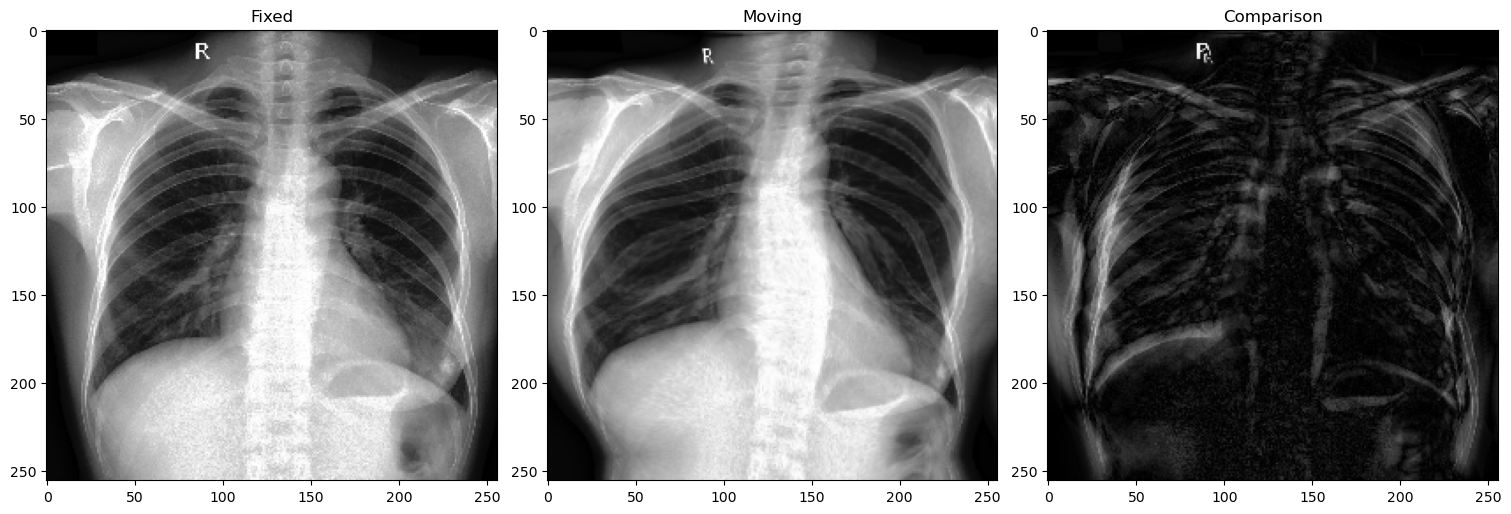

Method blend


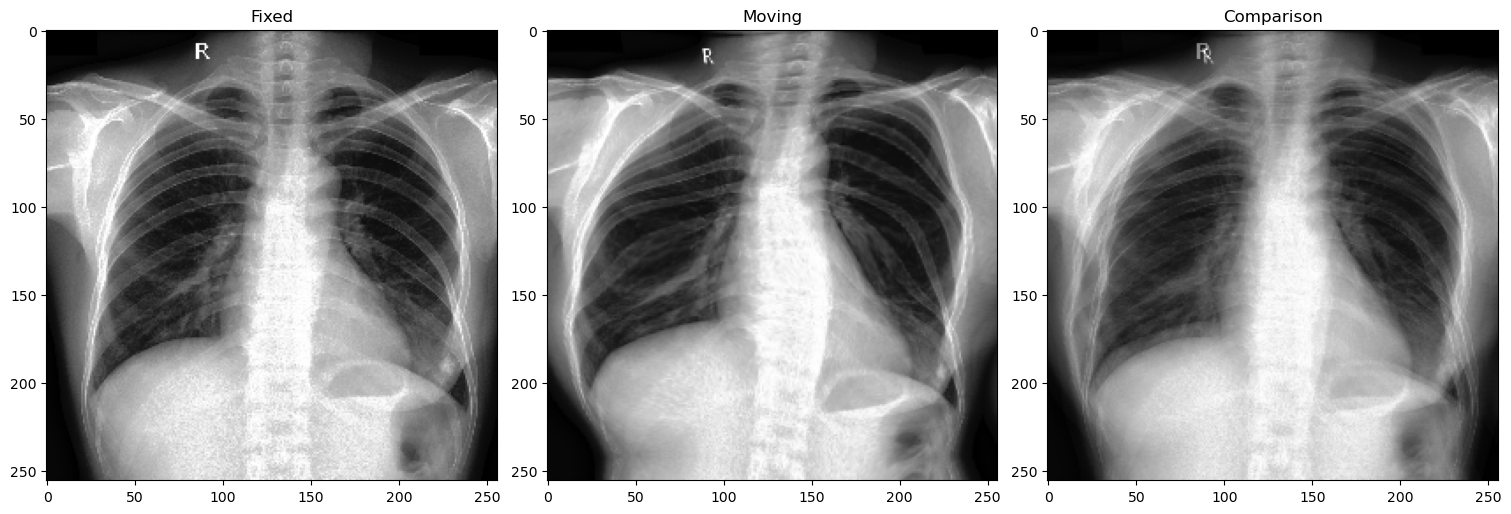

Method checkerboard


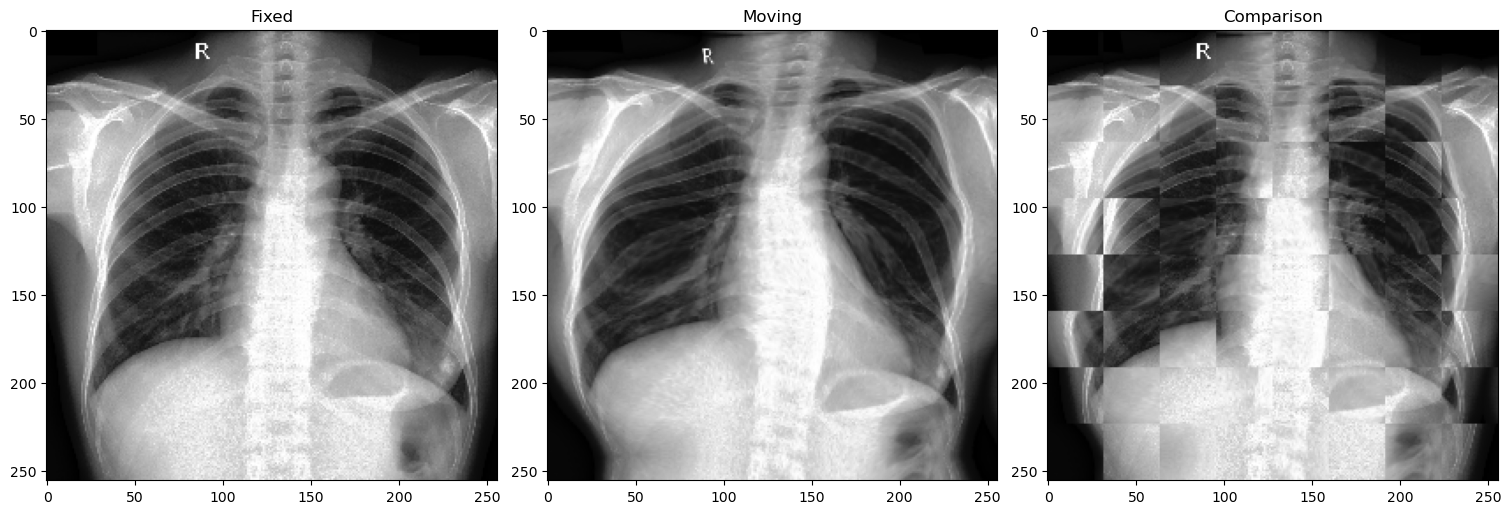

In [23]:
sample = train_dataset[0]
for method in ["diff", "blend", "checkerboard"]:
    print(f"Method {method}")
    visualize_fmc_sample(sample, method=method)

In [24]:
import tqdm

train_loader = monai.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

samples = []
for train_batch in tqdm.tqdm(train_loader):
    samples.append(train_batch)

# Make a new dataset and dataloader using the transformed images
train_dataset = monai.data.Dataset(samples, transform=monai.transforms.SqueezeDimd(keys=['fixed', 'moving', 'fixed_mask', 'moving_mask']))
train_loader = monai.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

  0%|                                                 | 0/195 [00:00<?, ?it/s]

  1%|▏                                        | 1/195 [00:00<01:10,  2.76it/s]

  1%|▍                                        | 2/195 [00:00<01:04,  3.01it/s]

  2%|▋                                        | 3/195 [00:00<01:01,  3.13it/s]

  2%|▊                                        | 4/195 [00:01<01:04,  2.97it/s]

  3%|█                                        | 5/195 [00:01<01:02,  3.05it/s]

  3%|█▎                                       | 6/195 [00:02<01:15,  2.49it/s]

  4%|█▍                                       | 7/195 [00:02<01:27,  2.14it/s]

  4%|█▋                                       | 8/195 [00:03<01:30,  2.07it/s]

  5%|█▉                                       | 9/195 [00:03<01:28,  2.11it/s]

  5%|██                                      | 10/195 [00:04<01:17,  2.39it/s]

  6%|██▎                                     | 11/195 [00:04<01:19,  2.32it/s]

  6%|██▍                                     | 12/195 [00:05<01:21,  2.24it/s]

  7%|██▋                                     | 13/195 [00:05<01:12,  2.51it/s]

  7%|██▊                                     | 14/195 [00:05<01:09,  2.61it/s]

  8%|███                                     | 15/195 [00:06<01:13,  2.43it/s]

  8%|███▎                                    | 16/195 [00:06<01:07,  2.65it/s]

  9%|███▍                                    | 17/195 [00:06<01:03,  2.80it/s]

  9%|███▋                                    | 18/195 [00:07<01:00,  2.92it/s]

 10%|███▉                                    | 19/195 [00:07<00:53,  3.29it/s]

 10%|████                                    | 20/195 [00:07<01:02,  2.79it/s]

 11%|████▎                                   | 21/195 [00:08<01:05,  2.67it/s]

 11%|████▌                                   | 22/195 [00:08<01:07,  2.57it/s]

 12%|████▋                                   | 23/195 [00:08<01:01,  2.78it/s]

 12%|████▉                                   | 24/195 [00:09<00:59,  2.87it/s]

 13%|█████▏                                  | 25/195 [00:09<01:02,  2.72it/s]

 13%|█████▎                                  | 26/195 [00:10<01:08,  2.45it/s]

 14%|█████▌                                  | 27/195 [00:10<01:12,  2.31it/s]

 14%|█████▋                                  | 28/195 [00:11<01:14,  2.24it/s]

 15%|█████▉                                  | 29/195 [00:11<01:19,  2.09it/s]

 15%|██████▏                                 | 30/195 [00:11<01:12,  2.28it/s]

 16%|██████▎                                 | 31/195 [00:12<01:10,  2.32it/s]

 16%|██████▌                                 | 32/195 [00:12<01:13,  2.22it/s]

 17%|██████▊                                 | 33/195 [00:13<01:11,  2.27it/s]

 17%|██████▉                                 | 34/195 [00:13<01:16,  2.10it/s]

 18%|███████▏                                | 35/195 [00:14<01:11,  2.23it/s]

 18%|███████▍                                | 36/195 [00:14<01:04,  2.47it/s]

 19%|███████▌                                | 37/195 [00:14<01:02,  2.51it/s]

 19%|███████▊                                | 38/195 [00:15<00:58,  2.69it/s]

 20%|████████                                | 39/195 [00:15<01:03,  2.46it/s]

 21%|████████▏                               | 40/195 [00:16<01:06,  2.34it/s]

 21%|████████▍                               | 41/195 [00:16<01:00,  2.55it/s]

 22%|████████▌                               | 42/195 [00:16<01:00,  2.53it/s]

 22%|████████▊                               | 43/195 [00:17<01:03,  2.39it/s]

 23%|█████████                               | 44/195 [00:17<00:57,  2.62it/s]

 23%|█████████▏                              | 45/195 [00:17<00:53,  2.80it/s]

 24%|█████████▍                              | 46/195 [00:18<00:55,  2.68it/s]

 24%|█████████▋                              | 47/195 [00:18<00:54,  2.71it/s]

 25%|█████████▊                              | 48/195 [00:19<00:56,  2.59it/s]

 25%|██████████                              | 49/195 [00:19<01:00,  2.43it/s]

 26%|██████████▎                             | 50/195 [00:20<00:59,  2.45it/s]

 26%|██████████▍                             | 51/195 [00:20<00:59,  2.41it/s]

 27%|██████████▋                             | 52/195 [00:20<00:55,  2.56it/s]

 27%|██████████▊                             | 53/195 [00:21<00:57,  2.47it/s]

 28%|███████████                             | 54/195 [00:21<01:01,  2.30it/s]

 28%|███████████▎                            | 55/195 [00:22<00:55,  2.53it/s]

 29%|███████████▍                            | 56/195 [00:22<00:47,  2.90it/s]

 29%|███████████▋                            | 57/195 [00:22<00:41,  3.29it/s]

 30%|███████████▉                            | 58/195 [00:22<00:45,  3.02it/s]

 30%|████████████                            | 59/195 [00:23<00:49,  2.73it/s]

 31%|████████████▎                           | 60/195 [00:23<00:49,  2.71it/s]

 31%|████████████▌                           | 61/195 [00:24<00:48,  2.78it/s]

 32%|████████████▋                           | 62/195 [00:24<00:50,  2.61it/s]

 32%|████████████▉                           | 63/195 [00:24<00:54,  2.43it/s]

 33%|█████████████▏                          | 64/195 [00:25<00:59,  2.22it/s]

 33%|█████████████▎                          | 65/195 [00:25<00:57,  2.27it/s]

 34%|█████████████▌                          | 66/195 [00:26<00:58,  2.22it/s]

 34%|█████████████▋                          | 67/195 [00:26<00:56,  2.25it/s]

 35%|█████████████▉                          | 68/195 [00:27<00:50,  2.51it/s]

 35%|██████████████▏                         | 69/195 [00:27<00:53,  2.33it/s]

 36%|██████████████▎                         | 70/195 [00:27<00:48,  2.55it/s]

 36%|██████████████▌                         | 71/195 [00:28<00:51,  2.40it/s]

 37%|██████████████▊                         | 72/195 [00:28<00:56,  2.19it/s]

 37%|██████████████▉                         | 73/195 [00:29<00:49,  2.49it/s]

 38%|███████████████▏                        | 74/195 [00:29<00:52,  2.30it/s]

 38%|███████████████▍                        | 75/195 [00:30<00:48,  2.48it/s]

 39%|███████████████▌                        | 76/195 [00:30<00:41,  2.89it/s]

 39%|███████████████▊                        | 77/195 [00:30<00:44,  2.63it/s]

 40%|████████████████                        | 78/195 [00:31<00:48,  2.43it/s]

 41%|████████████████▏                       | 79/195 [00:31<00:52,  2.19it/s]

 41%|████████████████▍                       | 80/195 [00:32<00:51,  2.23it/s]

 42%|████████████████▌                       | 81/195 [00:32<00:48,  2.35it/s]

 42%|████████████████▊                       | 82/195 [00:33<00:51,  2.18it/s]

 43%|█████████████████                       | 83/195 [00:33<00:52,  2.15it/s]

 43%|█████████████████▏                      | 84/195 [00:33<00:46,  2.40it/s]

 44%|█████████████████▍                      | 85/195 [00:34<00:44,  2.49it/s]

 44%|█████████████████▋                      | 86/195 [00:34<00:49,  2.19it/s]

 45%|█████████████████▊                      | 87/195 [00:35<00:47,  2.30it/s]

 45%|██████████████████                      | 88/195 [00:35<00:46,  2.31it/s]

 46%|██████████████████▎                     | 89/195 [00:36<00:47,  2.25it/s]

 46%|██████████████████▍                     | 90/195 [00:36<00:49,  2.12it/s]

 47%|██████████████████▋                     | 91/195 [00:37<00:49,  2.10it/s]

 47%|██████████████████▊                     | 92/195 [00:37<00:49,  2.07it/s]

 48%|███████████████████                     | 93/195 [00:38<00:48,  2.10it/s]

 48%|███████████████████▎                    | 94/195 [00:38<00:47,  2.10it/s]

 49%|███████████████████▍                    | 95/195 [00:39<00:46,  2.15it/s]

 49%|███████████████████▋                    | 96/195 [00:39<00:43,  2.30it/s]

 50%|███████████████████▉                    | 97/195 [00:39<00:39,  2.45it/s]

 50%|████████████████████                    | 98/195 [00:40<00:41,  2.32it/s]

 51%|████████████████████▎                   | 99/195 [00:40<00:36,  2.60it/s]

 51%|████████████████████                   | 100/195 [00:40<00:39,  2.41it/s]

 52%|████████████████████▏                  | 101/195 [00:41<00:40,  2.31it/s]

 52%|████████████████████▍                  | 102/195 [00:41<00:39,  2.37it/s]

 53%|████████████████████▌                  | 103/195 [00:42<00:40,  2.28it/s]

 53%|████████████████████▊                  | 104/195 [00:42<00:38,  2.34it/s]

 54%|█████████████████████                  | 105/195 [00:43<00:40,  2.24it/s]

 54%|█████████████████████▏                 | 106/195 [00:43<00:36,  2.46it/s]

 55%|█████████████████████▍                 | 107/195 [00:44<00:37,  2.36it/s]

 55%|█████████████████████▌                 | 108/195 [00:44<00:39,  2.20it/s]

 56%|█████████████████████▊                 | 109/195 [00:44<00:35,  2.46it/s]

 56%|██████████████████████                 | 110/195 [00:45<00:31,  2.69it/s]

 57%|██████████████████████▏                | 111/195 [00:45<00:29,  2.87it/s]

 57%|██████████████████████▍                | 112/195 [00:45<00:27,  3.03it/s]

 58%|██████████████████████▌                | 113/195 [00:46<00:29,  2.74it/s]

 58%|██████████████████████▊                | 114/195 [00:46<00:32,  2.50it/s]

 59%|███████████████████████                | 115/195 [00:46<00:29,  2.71it/s]

 59%|███████████████████████▏               | 116/195 [00:47<00:32,  2.43it/s]

 60%|███████████████████████▍               | 117/195 [00:47<00:30,  2.57it/s]

 61%|███████████████████████▌               | 118/195 [00:48<00:28,  2.66it/s]

 61%|███████████████████████▊               | 119/195 [00:48<00:26,  2.86it/s]

 62%|████████████████████████               | 120/195 [00:48<00:25,  2.98it/s]

 62%|████████████████████████▏              | 121/195 [00:49<00:24,  3.06it/s]

 63%|████████████████████████▍              | 122/195 [00:49<00:26,  2.76it/s]

 63%|████████████████████████▌              | 123/195 [00:49<00:26,  2.68it/s]

 64%|████████████████████████▊              | 124/195 [00:50<00:28,  2.49it/s]

 64%|█████████████████████████              | 125/195 [00:50<00:28,  2.42it/s]

 65%|█████████████████████████▏             | 126/195 [00:51<00:26,  2.63it/s]

 65%|█████████████████████████▍             | 127/195 [00:51<00:28,  2.40it/s]

 66%|█████████████████████████▌             | 128/195 [00:51<00:25,  2.64it/s]

 66%|█████████████████████████▊             | 129/195 [00:52<00:27,  2.41it/s]

 67%|██████████████████████████             | 130/195 [00:52<00:28,  2.30it/s]

 67%|██████████████████████████▏            | 131/195 [00:53<00:27,  2.34it/s]

 68%|██████████████████████████▍            | 132/195 [00:53<00:24,  2.56it/s]

 68%|██████████████████████████▌            | 133/195 [00:54<00:25,  2.40it/s]

 69%|██████████████████████████▊            | 134/195 [00:54<00:25,  2.40it/s]

 69%|███████████████████████████            | 135/195 [00:54<00:26,  2.27it/s]

 70%|███████████████████████████▏           | 136/195 [00:55<00:23,  2.50it/s]

 70%|███████████████████████████▍           | 137/195 [00:55<00:23,  2.47it/s]

 71%|███████████████████████████▌           | 138/195 [00:56<00:22,  2.56it/s]

 71%|███████████████████████████▊           | 139/195 [00:56<00:22,  2.47it/s]

 72%|████████████████████████████           | 140/195 [00:56<00:23,  2.35it/s]

 72%|████████████████████████████▏          | 141/195 [00:57<00:20,  2.66it/s]

 73%|████████████████████████████▍          | 142/195 [00:57<00:20,  2.57it/s]

 73%|████████████████████████████▌          | 143/195 [00:57<00:18,  2.79it/s]

 74%|████████████████████████████▊          | 144/195 [00:58<00:18,  2.71it/s]

 74%|█████████████████████████████          | 145/195 [00:58<00:20,  2.40it/s]

 75%|█████████████████████████████▏         | 146/195 [00:59<00:18,  2.58it/s]

 75%|█████████████████████████████▍         | 147/195 [00:59<00:17,  2.81it/s]

 76%|█████████████████████████████▌         | 148/195 [00:59<00:15,  3.11it/s]

 76%|█████████████████████████████▊         | 149/195 [00:59<00:14,  3.20it/s]

 77%|██████████████████████████████         | 150/195 [01:00<00:16,  2.74it/s]

 77%|██████████████████████████████▏        | 151/195 [01:00<00:16,  2.64it/s]

 78%|██████████████████████████████▍        | 152/195 [01:01<00:14,  2.87it/s]

 78%|██████████████████████████████▌        | 153/195 [01:01<00:14,  3.00it/s]

 79%|██████████████████████████████▊        | 154/195 [01:01<00:15,  2.59it/s]

 79%|██████████████████████████████▉        | 155/195 [01:02<00:13,  2.97it/s]

 80%|███████████████████████████████▏       | 156/195 [01:02<00:12,  3.07it/s]

 81%|███████████████████████████████▍       | 157/195 [01:02<00:12,  3.14it/s]

 81%|███████████████████████████████▌       | 158/195 [01:03<00:12,  2.90it/s]

 82%|███████████████████████████████▊       | 159/195 [01:03<00:13,  2.77it/s]

 82%|████████████████████████████████       | 160/195 [01:03<00:12,  2.70it/s]

 83%|████████████████████████████████▏      | 161/195 [01:04<00:12,  2.63it/s]

 83%|████████████████████████████████▍      | 162/195 [01:04<00:11,  2.79it/s]

 84%|████████████████████████████████▌      | 163/195 [01:04<00:10,  2.92it/s]

 84%|████████████████████████████████▊      | 164/195 [01:05<00:10,  3.09it/s]

 85%|█████████████████████████████████      | 165/195 [01:05<00:10,  2.88it/s]

 85%|█████████████████████████████████▏     | 166/195 [01:05<00:09,  3.02it/s]

 86%|█████████████████████████████████▍     | 167/195 [01:06<00:09,  3.10it/s]

 86%|█████████████████████████████████▌     | 168/195 [01:06<00:08,  3.14it/s]

 87%|█████████████████████████████████▊     | 169/195 [01:06<00:08,  2.97it/s]

 87%|██████████████████████████████████     | 170/195 [01:07<00:08,  3.11it/s]

 88%|██████████████████████████████████▏    | 171/195 [01:07<00:08,  2.90it/s]

 88%|██████████████████████████████████▍    | 172/195 [01:07<00:08,  2.87it/s]

 89%|██████████████████████████████████▌    | 173/195 [01:08<00:08,  2.74it/s]

 89%|██████████████████████████████████▊    | 174/195 [01:08<00:08,  2.58it/s]

 90%|███████████████████████████████████    | 175/195 [01:09<00:06,  2.89it/s]

 90%|███████████████████████████████████▏   | 176/195 [01:09<00:06,  2.78it/s]

 91%|███████████████████████████████████▍   | 177/195 [01:09<00:06,  2.90it/s]

 91%|███████████████████████████████████▌   | 178/195 [01:10<00:05,  3.03it/s]

 92%|███████████████████████████████████▊   | 179/195 [01:10<00:05,  2.78it/s]

 92%|████████████████████████████████████   | 180/195 [01:10<00:05,  2.58it/s]

 93%|████████████████████████████████████▏  | 181/195 [01:11<00:05,  2.57it/s]

 93%|████████████████████████████████████▍  | 182/195 [01:11<00:04,  2.60it/s]

 94%|████████████████████████████████████▌  | 183/195 [01:12<00:04,  2.54it/s]

 94%|████████████████████████████████████▊  | 184/195 [01:12<00:03,  2.98it/s]

 95%|█████████████████████████████████████  | 185/195 [01:12<00:03,  3.08it/s]

 95%|█████████████████████████████████████▏ | 186/195 [01:12<00:02,  3.13it/s]

 96%|█████████████████████████████████████▍ | 187/195 [01:13<00:02,  3.04it/s]

 96%|█████████████████████████████████████▌ | 188/195 [01:13<00:02,  3.10it/s]

 97%|█████████████████████████████████████▊ | 189/195 [01:14<00:02,  2.88it/s]

 97%|██████████████████████████████████████ | 190/195 [01:14<00:01,  2.96it/s]

 98%|██████████████████████████████████████▏| 191/195 [01:14<00:01,  2.61it/s]

 98%|██████████████████████████████████████▍| 192/195 [01:15<00:01,  2.55it/s]

 99%|██████████████████████████████████████▌| 193/195 [01:15<00:00,  2.47it/s]

 99%|██████████████████████████████████████▊| 194/195 [01:15<00:00,  2.69it/s]

100%|███████████████████████████████████████| 195/195 [01:16<00:00,  2.89it/s]

100%|███████████████████████████████████████| 195/195 [01:16<00:00,  2.56it/s]

In [25]:
# Your code goes here

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"
else:
    device = "cpu"
print(f'The used device is {device}')

The used device is mps


In [27]:
model = # FILL IN

warp_layer = monai.networks.blocks.Warp().to(device)

SyntaxError: invalid syntax (1914504081.py, line 1)

In [28]:
image_loss = torch.nn.MSELoss()
regularization = monai.losses.BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

NameError: name 'model' is not defined

In [29]:
# Your code goes here

In [30]:
def forward(batch_data, model):
    """
    Applies the model to a batch of data.
    
    Args:
        batch_data (dict): a batch of samples computed by a DataLoader.
        model (Module): a model computing the deformation field.
    
    Returns:
        ddf (Tensor): batch of deformation fields.
        pred_image (Tensor): batch of deformed moving images.
    
    """
    fixed_image = batch_data["fixed"].to(device).float()
    moving_image = batch_data["moving"].to(device).float()
    
    # predict DDF
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))

    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf)

    return ddf, pred_image

In [31]:
def log_to_wandb(epoch, train_loss, val_loss, pred_batch, fixed_batch, method="checkerboard"):
    """ Function that logs ongoing training variables to W&B """
    import skimage.util as skut
    
    log_imgs = []
    for fixed_pt, pred_pt in zip(pred_batch, fixed_batch):
        fixed_np = np.squeeze(fixed_pt.cpu().detach())
        pred_np = np.squeeze(pred_pt.cpu().detach())
        comp_checker = skut.compare_images(fixed_np, pred_np, method=method)
        log_imgs.append(wandb.Image(comp_checker))

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss, 'results': log_imgs})

In [32]:
# Choose your parameters

max_epochs = 200
reg_weight = 0 # By default 0, but you can investigate what it does

In [33]:
from tqdm import tqdm

run = wandb.init(
    project='tutorial4_registration',
    config={
        'lr': optimizer.param_groups[0]["lr"],
        'batch_size': train_loader.batch_size,
        'regularization': reg_weight,
        'loss_function': str(image_loss)
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

for epoch in tqdm(range(max_epochs)):    
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        optimizer.zero_grad()

        ddf, pred_image = forward(batch_data, model)

        fixed_image = batch_data["fixed"].to(device).float()
        reg = regularization(ddf)
        loss = image_loss(pred_image, fixed_image) + reg_weight * reg
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    model.eval()
    val_epoch_loss = 0
    for batch_data in val_loader:
        ddf, pred_image = forward(batch_data, model)
        fixed_image = batch_data["fixed"].to(device).float()
        reg = regularization(ddf)
        loss = image_loss(pred_image, fixed_image) + reg_weight * reg
        val_epoch_loss += loss.item()
    val_epoch_loss /= len(val_loader)

    log_to_wandb(epoch, epoch_loss, val_epoch_loss, pred_image, fixed_image)
    
run.finish()    

NameError: name 'optimizer' is not defined

In [34]:
def visualize_prediction(sample, model, method="checkerboard"):
    """
    Plot three images: fixed, moving and comparison.
    
    Args:
        sample (dict): sample of dataset created with `build_dataset`.
        model (Module): a model computing the deformation field.
        method (str): method used by `skimage.util.compare_image`.
    """
    import skimage.util as skut 
    
    skut_methods = ["diff", "blend", "checkerboard"]
    if method not in skut_methods:
        raise ValueError(f"Method must be chosen in {skut_methods}.\n"
                         f"Current value is {method}.")
        
    model.eval()
    
    # Compute deformation field + deformed image
    batch_data = {
        "fixed": sample["fixed"].unsqueeze(0),
        "moving": sample["moving"].unsqueeze(0),
    }
    ddf, pred_image = forward(batch_data, model)
    ddf = ddf.detach().cpu().numpy().squeeze()
    ddf = np.linalg.norm(ddf, axis=0).squeeze()
    
    # Squeeze images
    fixed = np.squeeze(sample["fixed"])
    moving = np.squeeze(sample["moving"])    
    deformed = np.squeeze(pred_image.detach().cpu())
    
    # Generate comparison image
    comp_checker = skut.compare_images(fixed, deformed, method=method, n_tiles=(4, 4))
    
    # Plot everything
    fig, axs = plt.subplots(1, 5, figsize=(18, 5))    
    axs[0].imshow(fixed, cmap='gray')
    axs[0].set_title('Fixed')
    axs[1].imshow(moving, cmap='gray')
    axs[1].set_title('Moving')
    axs[2].imshow(deformed, cmap='gray')
    axs[2].set_title('Deformed')
    axs[3].imshow(comp_checker, cmap='gray')
    axs[3].set_title('Comparison')    
    dpl = axs[4].imshow(ddf, clim=(0, 10))
    fig.colorbar(dpl, ax=axs[4])
    plt.show()   
    plt.show()
for sample in val_dataset:
    visualize_prediction(sample, model)

NameError: name 'val_dataset' is not defined